## Задача 1

Реализовать класс для работы с линейной регрессией

In [1]:
import time
import numpy as np
import pandas as pd

class MyLinearRegression:
    """
    Параметры
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'),
        градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd').
        При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.

    Атрибуты
    ----------
    coefs_ : np.ndarray формы (p,) — коэффициенты при признаках.
    intercept_ : float — свободный член (смещение).
    """

    def __init__(self, regularization=None, weight_calc='matrix',
                 lambda_1=None, lambda_2=None, batch_size=20):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError("Значение коэффициента регуляризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError("Значение коэффициента регуляризации l2 не задано")
        if regularization in ['l1', 'l1l2'] and weight_calc == 'matrix':
            raise TypeError("При L1 или L1L2 нельзя использовать матричный метод ('matrix')")

        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size

        # гиперпараметры для (S)GD — можно менять снаружи
        self.learning_rate = 0.01
        self.n_iters = 1000

        # будут заданы после fit
        self.coefs_ = None
        self.intercept_ = None
        self.X_mean_ = None
        self.X_std_ = None

    def _standardize_fit(self, X):
        """
        Запомнить среднее и СКО по столбцам и вернуть стандартизированную матрицу.
        """
        X = np.asarray(X, dtype=float)
        self.X_mean_ = X.mean(axis=0)
        self.X_std_ = X.std(axis=0)
        # чтобы не делить на ноль
        self.X_std_[self.X_std_ == 0] = 1.0
        X_scaled = (X - self.X_mean_) / self.X_std_
        return X_scaled

    def _standardize_transform(self, X):
        """
        Преобразовать X по уже сохранённым параметрам стандартизации.
        """
        X = np.asarray(X, dtype=float)
        if self.X_mean_ is None or self.X_std_ is None:
            return X
        X_scaled = (X - self.X_mean_) / self.X_std_
        return X_scaled

    def _fit_matrix(self, X, y):
        """
        Матричное решение (обычная или ridge-регрессия).
        L1 и elastic net не поддерживаются (запрещены в __init__).
        """
        n_samples, n_features = X.shape
        # добавляем столбец единиц для интерсепта
        Xb = np.hstack([np.ones((n_samples, 1)), X])  # (n, p+1)
        y = y.reshape(-1, 1)  # (n, 1)

        if self.regularization is None:
            # (X^T X)^(-1) X^T y
            A = Xb.T @ Xb
            b = Xb.T @ y
        elif self.regularization == 'l2':
            # (X^T X + λI)^(-1) X^T y, не штрафуем интерсепт
            reg_matrix = self.lambda_2 * np.eye(Xb.shape[1])
            reg_matrix[0, 0] = 0.0  # интерсепт не регуляризуем
            A = Xb.T @ Xb + reg_matrix
            b = Xb.T @ y
        else:
            raise ValueError("Неверная комбинация regularization/weight_calc (должно быть уже отфильтровано).")

        w_all = np.linalg.pinv(A) @ b  # (p+1, 1)

        self.intercept_ = float(w_all[0])
        self.coefs_ = w_all[1:, 0]

    def _fit_gd(self, X, y, stochastic=False):
        """
        Градиентный спуск / стохастический градиентный спуск.
        """
        n_samples, n_features = X.shape
        y = y.reshape(-1)

        # инициализация весов
        w = np.zeros(n_features)
        b = 0.0

        lr = self.learning_rate
        n_iters = self.n_iters

        rng = np.random.default_rng(42)

        for epoch in range(n_iters):
            if stochastic:
                # SGD: перемешиваем индексы и идём по батчам
                indices = rng.permutation(n_samples)
                for start in range(0, n_samples, self.batch_size):
                    end = start + self.batch_size
                    batch_idx = indices[start:end]
                    X_batch = X[batch_idx]
                    y_batch = y[batch_idx]

                    n_batch = X_batch.shape[0]
                    y_pred = X_batch @ w + b
                    error = y_pred - y_batch

                    # производные MSE
                    dw = (2.0 / n_batch) * (X_batch.T @ error)
                    db = (2.0 / n_batch) * error.sum()

                    # регуляризация (без штрафа на b)
                    if self.regularization in ['l2', 'l1l2']:
                        dw += 2 * self.lambda_2 * w
                    if self.regularization in ['l1', 'l1l2']:
                        dw += self.lambda_1 * np.sign(w)

                    w -= lr * dw
                    b -= lr * db
            else:
                # полный градиентный спуск
                y_pred = X @ w + b
                error = y_pred - y

                dw = (2.0 / n_samples) * (X.T @ error)
                db = (2.0 / n_samples) * error.sum()

                if self.regularization in ['l2', 'l1l2']:
                    dw += 2 * self.lambda_2 * w
                if self.regularization in ['l1', 'l1l2']:
                    dw += self.lambda_1 * np.sign(w)

                w -= lr * dw
                b -= lr * db

        self.coefs_ = w
        self.intercept_ = b

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        """
        Обучение модели.
        X — DataFrame или ndarray с признаками,
        y — Series / DataFrame / ndarray с целевой переменной.
        """
        # приводим к numpy
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X_np = X.values
        else:
            X_np = np.asarray(X, dtype=float)

        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y_np = y.values.reshape(-1)
        else:
            y_np = np.asarray(y, dtype=float).reshape(-1)

        # стандартизируем признаки
        X_scaled = self._standardize_fit(X_np)

        # выбираем способ вычисления весов
        if self.weight_calc == 'matrix':
            self._fit_matrix(X_scaled, y_np)
        elif self.weight_calc == 'gd':
            self._fit_gd(X_scaled, y_np, stochastic=False)
        elif self.weight_calc == 'sgd':
            self._fit_gd(X_scaled, y_np, stochastic=True)
        else:
            raise ValueError("Неизвестный метод вычисления весов")

        return self

    def predict(self, X, ss=True):
        """
        Предсказание.
        X — DataFrame или ndarray.
        ss : если True, то применяем сохранённую стандартизацию.
        """
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X_np = X.values
        else:
            X_np = np.asarray(X, dtype=float)

        if ss:
            X_scaled = self._standardize_transform(X_np)
        else:
            X_scaled = X_np

        y_pred = X_scaled @ self.coefs_ + self.intercept_
        return y_pred

    def score(self, X, y):
        """
        Коэффициент детерминации R^2.
        """
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X_np = X.values
        else:
            X_np = np.asarray(X, dtype=float)

        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y_np = y.values.reshape(-1)
        else:
            y_np = np.asarray(y, dtype=float).reshape(-1)

        y_pred = self.predict(X_np)
        ss_res = np.sum((y_np - y_pred) ** 2)
        ss_tot = np.sum((y_np - y_np.mean()) ** 2)

        return 1 - ss_res / ss_tot

Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import math

df = pd.read_csv("/content/Used_fiat_500_in_Italy_dataset.csv")
target_col = "price"

df = df.dropna(subset=[target_col])

y = df[target_col]
X = df.drop(columns=[target_col])

X = pd.get_dummies(X, drop_first=True)

X = X.fillna(X.median(numeric_only=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """
    Обучаем модель, замеряем время обучения и предсказания,
    считаем метрики и возвращаем всё в виде dict.
    """
    result = {"model": name}

    # время обучения
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    t1 = time.perf_counter()
    train_time = t1 - t0

    # время предсказания
    t0 = time.perf_counter()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    t1 = time.perf_counter()
    pred_time = t1 - t0

    # метрики
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    result.update({
        "train_R2": train_r2,
        "test_R2": test_r2,
        "train_RMSE": train_rmse,
        "test_RMSE": test_rmse,
        "train_time": train_time,
        "pred_time": pred_time,
    })

    # важность признаков (модуль коэффициента)
    if hasattr(model, "coef_"):  # sklearn LinearRegression
        coefs = model.coef_
    else:
        coefs = model.coefs_

    result["feature_importance"] = pd.Series(
        np.abs(coefs),
        index=X_train.columns
    ).sort_values(ascending=False)

    return result


In [10]:
results = []

# 1. MyLinearRegression: без регуляризации, матричный метод
model1 = MyLinearRegression(regularization=None, weight_calc="matrix")
res1 = evaluate_model("MyLR_None_matrix", model1, X_train, y_train, X_test, y_test)
results.append(res1)

# 2. MyLinearRegression: L2 (ridge), матричный метод
model2 = MyLinearRegression(regularization="l2", weight_calc="matrix", lambda_2=1.0)
res2 = evaluate_model("MyLR_L2_matrix", model2, X_train, y_train, X_test, y_test)
results.append(res2)

# 3. MyLinearRegression: без регуляризации, GD
model3 = MyLinearRegression(regularization=None, weight_calc="gd")
model3.learning_rate = 0.01
model3.n_iters = 1000
res3 = evaluate_model("MyLR_None_gd", model3, X_train, y_train, X_test, y_test)
results.append(res3)

# 4. MyLinearRegression: L2, GD
model4 = MyLinearRegression(regularization="l2", weight_calc="gd", lambda_2=0.1)
model4.learning_rate = 0.01
model4.n_iters = 1000
res4 = evaluate_model("MyLR_L2_gd", model4, X_train, y_train, X_test, y_test)
results.append(res4)

# 5. MyLinearRegression: L1, GD
model5 = MyLinearRegression(regularization="l1", weight_calc="gd", lambda_1=0.01)
model5.learning_rate = 0.005
model5.n_iters = 1500
res5 = evaluate_model("MyLR_L1_gd", model5, X_train, y_train, X_test, y_test)
results.append(res5)

# 6. MyLinearRegression: elastic net (L1+L2), SGD
model6 = MyLinearRegression(regularization="l1l2", weight_calc="sgd", lambda_1=0.01, lambda_2=0.01, batch_size=32)
model6.learning_rate = 0.01
model6.n_iters = 30   # эпохи (по всем батчам)
res6 = evaluate_model("MyLR_L1L2_sgd", model6, X_train, y_train, X_test, y_test)
results.append(res6)

# 7. sklearn LinearRegression (библиотека)
sk_model = LinearRegression()
res_sk = evaluate_model("sklearn_LinearRegression", sk_model, X_train, y_train, X_test, y_test)
results.append(res_sk)

# Собираем всё в таблицу
rows = []
for r in results:
    row = {
        "model": r["model"],
        "train_R2": r["train_R2"],
        "test_R2": r["test_R2"],
        "train_RMSE": r["train_RMSE"],
        "test_RMSE": r["test_RMSE"],
        "train_time": r["train_time"],
        "pred_time": r["pred_time"],
    }
    rows.append(row)

res_df = pd.DataFrame(rows)
res_df


/tmp/ipython-input-577754353.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.intercept_ = float(w_all[0])
/tmp/ipython-input-577754353.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.intercept_ = float(w_all[0])


,model,train_R2,test_R2,train_RMSE,test_RMSE,train_time,pred_time
0,MyLR_None_matrix,0.839728,0.894534,855.130896,733.731322,0.018242,0.007071
1,MyLR_L2_matrix,0.839719,0.894395,855.154578,734.213111,0.010195,0.013390
2,MyLR_None_gd,0.839727,0.894410,855.133139,734.162607,0.135948,0.007326
3,MyLR_L2_gd,0.834274,0.886592,869.557351,760.854621,0.061072,0.000885
4,MyLR_L1_gd,0.839716,0.894071,855.163488,735.339872,0.045735,0.000944
5,MyLR_L1L2_sgd,0.837759,0.886966,860.367069,759.599105,0.013076,0.000855
6,sklearn_LinearRegression,0.839728,0.894534,855.130896,733.731322,0.032901,0.004858


/tmp/ipython-input-3890403944.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(res_df["model"], rotation=45, ha="right")
/tmp/ipython-input-3890403944.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(res_df["model"], rotation=45, ha="right")


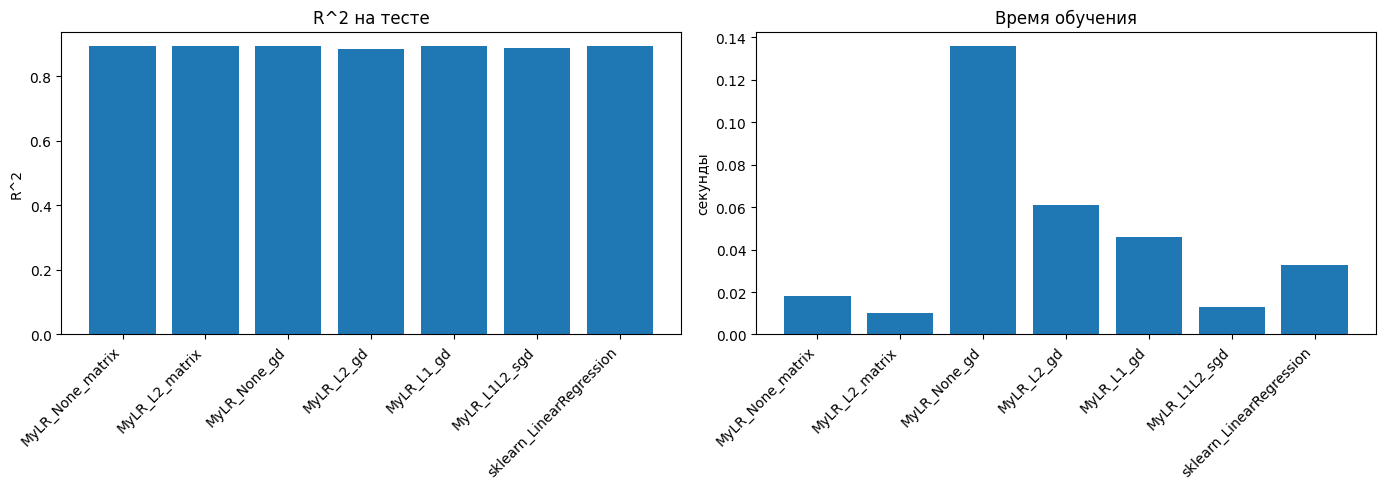

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(res_df["model"], res_df["test_R2"])
axes[0].set_title("R^2 на тесте")
axes[0].set_ylabel("R^2")
axes[0].set_xticklabels(res_df["model"], rotation=45, ha="right")

axes[1].bar(res_df["model"], res_df["train_time"])
axes[1].set_title("Время обучения")
axes[1].set_ylabel("секунды")
axes[1].set_xticklabels(res_df["model"], rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [13]:

for r in results:
    print("\nМодель:", r["model"])
    print("Топ-10 признаков по |коэффициенту|:")
    print(r["feature_importance"].head(10))



Модель: MyLR_None_matrix
Топ-10 признаков по |коэффициенту|:
age_in_days            1533.837809
km                      556.685210
lon                     252.261034
lat                     194.473519
model_sport              54.641213
previous_owners          50.413363
model_pop                46.634749
engine_power             39.824028
model_star               35.700712
transmission_manual       3.124951
dtype: float64

Модель: MyLR_L2_matrix
Топ-10 признаков по |коэффициенту|:
age_in_days            1525.523204
km                      560.162155
lon                     248.933054
lat                     191.301436
model_sport              53.442064
previous_owners          50.401081
model_pop                45.398972
engine_power             38.753306
model_star               36.256041
transmission_manual       3.415722
dtype: float64

Модель: MyLR_None_gd
Топ-10 признаков по |коэффициенту|:
age_in_days            1531.712357
km                      558.591973
lon                 

| Модель                       | Основные особенности важности признаков                                                               |
| ---------------------------- | ----------------------------------------------------------------------------------------------------- |
| **MyLR_None_matrix / GD**    | Большие веса у возраст–пробег–география; чувствительна к масштабу.                                    |
| **MyLR_L2 (matrix/GD)**      | Сглаживает веса, делает модель стабильнее, не меняя порядок важности.                                 |
| **MyLR_L1 (GD)**             | Чуть уменьшает второстепенные признаки, но ключевые остаются доминирующими.                           |
| **MyLR_L1L2 (SGD)**          | Сильно уменьшает ряд признаков — делает модель компактнее.                                            |
| **sklearn LinearRegression** | Из-за отсутствия стандартизации коэффициенты несопоставимы по масштабу — структура важности искажена. |
